# Automated Wafer Defect Detection and Pattern Recognition Using Deep Learning (In Progress)



### Overview

In semiconductor manufacturing, detecting defects on wafers (thin slices of semiconductor material used in electronics) is crucial for ensuring product quality. Traditionally, this process involves manual inspection or basic automation tools, which are time-consuming and less efficient. Deep learning provides a modern, automated solution by training neural networks to recognize patterns and defects in wafer images, significantly improving accuracy and speed.

In [1]:
# Load package
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=1) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.gridspec as gridspec


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image

import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings

# Suppress specific warning about FixedFormatter
warnings.filterwarnings("ignore", category=UserWarning, message=".*FixedFormatter.*")

# Your plotting code here


/var/folders/ww/2phdrqvx0k7b9qmqm0v7m2s40000gn/T/ipykernel_170/1733500790.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data Cleaning and EDA

### About the WM811K Wafer Map Dataset

The **WM811K Wafer Map Dataset** is a large, real-world dataset consisting of **811,457 wafer maps** from **46,393 different lots** in semiconductor fabrication. Wafer maps are visual representations of semiconductor wafer test results, showing the spatial distribution of failures across the wafer's surface. This dataset is widely used in research for machine learning, particularly in the development of defect detection and pattern recognition models.

#### Key Features of the Dataset:
- **Size**: The dataset contains **811,457 wafer maps**, making it one of the most comprehensive wafer map datasets available for defect analysis.
- **Origin**: The maps come from **46,393 lots** of semiconductor manufacturing processes, which reflect various real-world conditions in fabrication plants.
- **Purpose**: The data is primarily used for the classification of **wafer defect types** and for training machine learning models to automatically detect defects in semiconductor wafers.

#### Wafer Defect Types in the Dataset:
The dataset includes several distinct **defect types** typically found in semiconductor manufacturing. Here’s a list of the common defect patterns:

1. **Center**: Defects are concentrated at the center of the wafer.
2. **Donut**: A ring-shaped pattern, where defects are found surrounding a relatively defect-free center.
3. **Edge-Ring**: Defects appear around the edge of the wafer in a ring-like shape.
4. **Edge-Loc**: Defects are localized near the wafer’s edge.
5. **Loc**: Localized defects that appear in specific, concentrated regions.
6. **Random**: Defects are scattered randomly across the wafer, with no discernible pattern.
7. **Scratch**: A linear pattern of defects, often caused by physical damage or contamination.

#### Usage of the Dataset:
- **Classification**: The dataset can be used to train machine learning models to classify wafer maps based on defect types.
- **Pattern Recognition**: It serves as a benchmark for developing pattern recognition algorithms that detect and categorize defects.
- **Anomaly Detection**: The dataset is also valuable for studying anomalies in semiconductor manufacturing processes.

#### Dataset Availability:
You can access the dataset through Kaggle at this link: [WM811K Wafer Map Dataset](https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map).


Reference paper:
Wu, Ming-Ju, Jyh-Shing R. Jang, and Jui-Long Chen. “Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets.” IEEE Transactions on Semiconductor Manufacturing 28, no. 1 (February 2015): 1–12.

In [2]:
# Data
df = pd.read_pickle('../datasets/LSWMD.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


### WM811K Wafer Map Dataset Columns

1. **`waferMap`** (`object`):
   - Contains the actual **wafer maps** as image-like objects. Each wafer map visually represents the spatial distribution of defect patterns on a semiconductor wafer.

2. **`dieSize`** (`float64`):
   - Refers to the **size of the dies** (individual units) on the wafer. Dies are small blocks of semiconductor material where circuits are fabricated. This column captures the numeric size of the die in the wafer.

3. **`lotName`** (`object`):
   - Represents the **name or identifier of the lot** the wafer belongs to. A lot refers to a group of wafers processed together in a batch during semiconductor manufacturing.

4. **`waferIndex`** (`float64`):
   - Indicates the **index of the wafer** in the manufacturing lot. This numeric column shows the wafer's position within the batch or lot.

5. **`trianTestLabel`** (`object`):
   - Labels that classify each wafer map as either part of the **training set** or the **testing set**. This is used for partitioning the dataset for machine learning purposes.

6. **`failureType`** (`object`):
   - Contains the **type of failure or defect pattern** identified on the wafer, such as "Center", "Donut", "Edge-Ring", "Edge-Loc", etc. This helps in classifying the nature of defects on the wafer.



In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


---

### Wafer Index Distribution

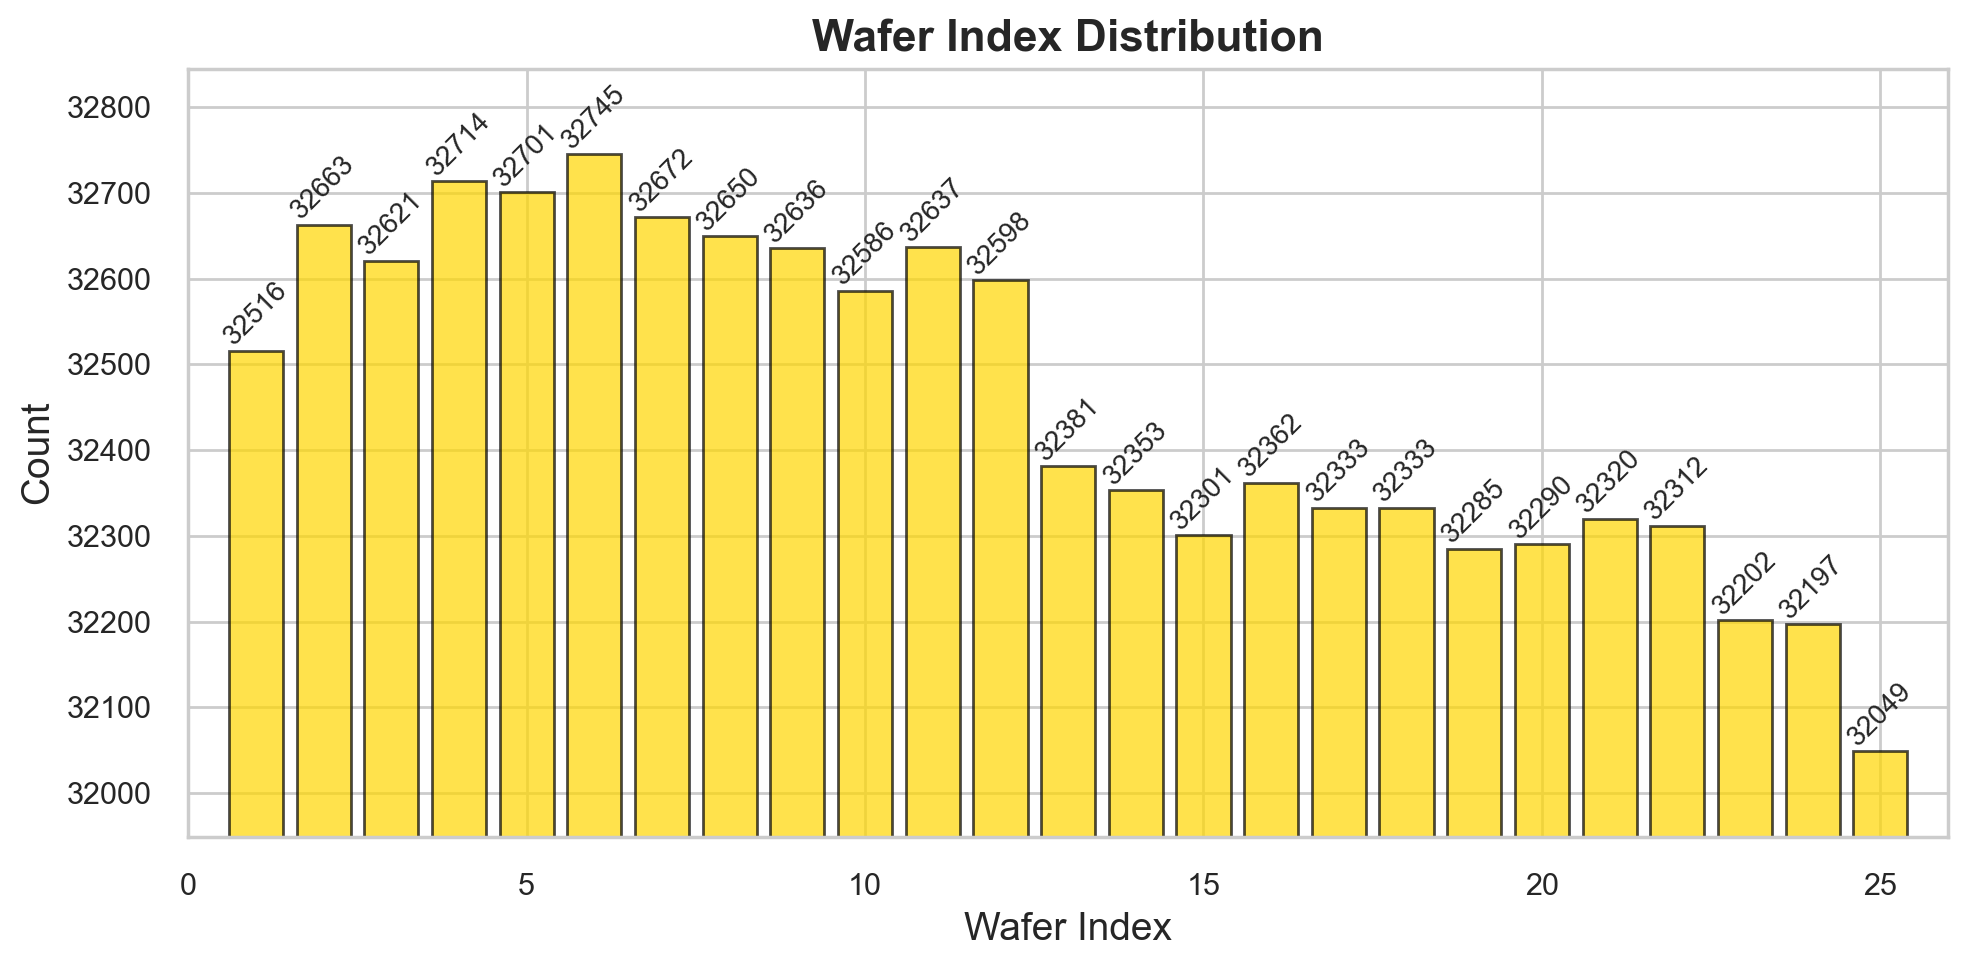

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style for a cleaner look
sns.set(style="whitegrid")

# Calculate wafer index distribution
wafer_counts = np.unique(df['waferIndex'], return_counts=True)

# Plot
plt.figure(figsize=(10, 5))  # Adjust figure size for better visibility
bars = plt.bar(wafer_counts[0], wafer_counts[1], color='gold', alpha=0.7, edgecolor='black')

# Add titles and labels with improved formatting
plt.title('Wafer Index Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Wafer Index', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Auto-scale axis limits based on data
plt.xlim(wafer_counts[0].min() - 1, wafer_counts[0].max() + 1)
plt.ylim(wafer_counts[1].min() - 100, wafer_counts[1].max() + 100)

# Add value annotations on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10, rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [5]:
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return (dim0, dim1)

df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
694972,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",793.0,lot42821,4.0,[[Test]],[[none]],"(32, 32)"
61519,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot4825,13.0,[],[],"(30, 34)"
698193,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,...",516.0,lot42951,1.0,[[Training]],[[none]],"(25, 27)"
341800,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2582.0,lot20491,9.0,[],[],"(59, 56)"
146460,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot9406,9.0,[],[],"(212, 84)"


In [6]:
unique_waferDim = np.unique(df['waferMapDim'])
unique_waferDim.shape

(632,)

In [7]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel

mapping_type={
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

This code filters the `df` DataFrame based on the values in the `failureNum` column to create three new DataFrames:

1. **`df_withlabel`**: 
   - Contains rows where `failureNum` is between 0 and 8 (inclusive). 
   - The index is reset for this DataFrame.

2. **`df_withpattern`**: 
   - Contains rows where `failureNum` is between 0 and 7 (inclusive). 
   - The index is reset for this DataFrame.

3. **`df_nonpattern`**: 
   - Contains rows where `failureNum` is exactly 8.

The final line outputs the number of rows in each of these DataFrames:
- `df_withlabel= 172950
- `df_withpattern = 25519
- `df_nonpattern = 147431


In [8]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)] 
df_withlabel = df_withlabel.reset_index() 
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)] 
df_withpattern = df_withpattern.reset_index() 
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0] 


(172950, 25519, 147431)

In [9]:
tol_wafers = df.shape[0]
tol_wafers

811457

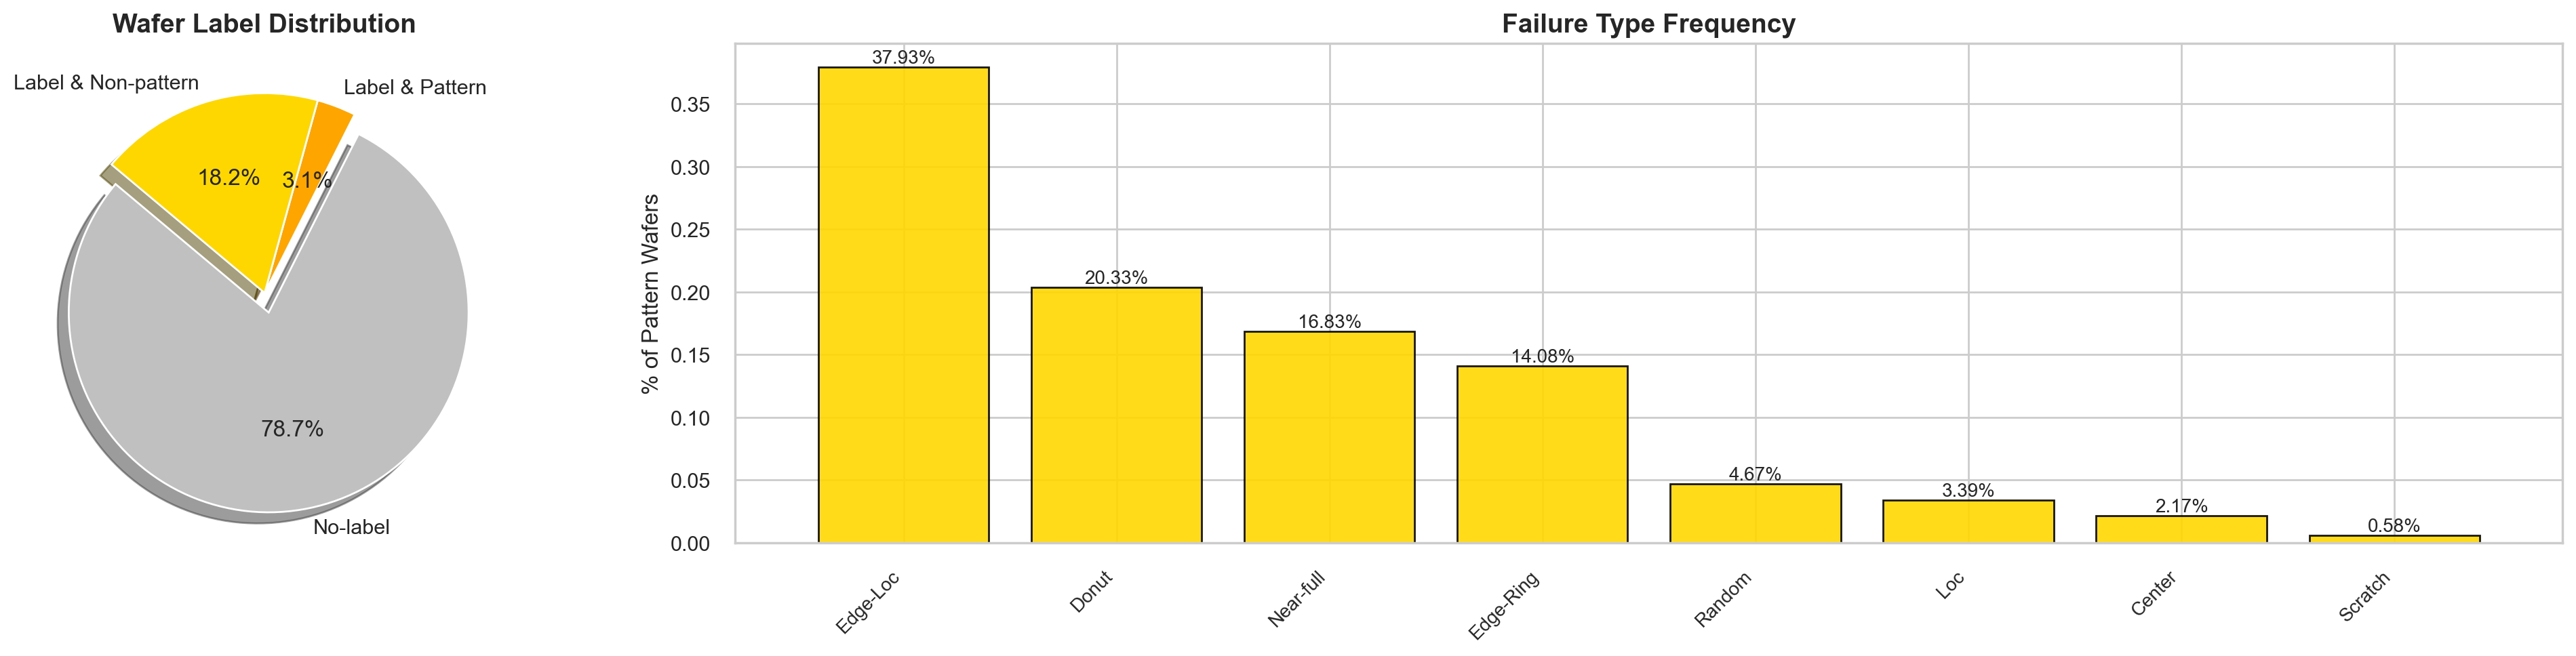

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Creating the figure and gridspec
fig = plt.figure(figsize=(20, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 

# Pie chart on the left
ax1 = plt.subplot(gs[0])
no_wafers = [tol_wafers - df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]
colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # Explode the first slice
labels = ['No-label', 'Label & Pattern', 'Label & Non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax1.set_title("Wafer Label Distribution", fontsize=14, fontweight='bold')

# Bar chart on the right, sorted by frequency
ax2 = plt.subplot(gs[1])

# Get the unique failure types and their counts
failure_counts = df_withpattern['failureNum'].value_counts()

# Sort the failure types based on frequency
sorted_failure_types = failure_counts.index
sorted_failure_counts = failure_counts.values / df_withpattern.shape[0]  # Normalize counts by total pattern wafers

# Failure type labels (adjust as necessary)
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full']
sorted_labels = [labels2[i - 1] for i in sorted_failure_types]  # Adjust for index starting at 1

# Plotting the sorted bar chart
bars = ax2.bar(sorted_labels, sorted_failure_counts, color='gold', alpha=0.9, edgecolor='black')

# Add percentage labels above bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2%}', ha='center', va='bottom', fontsize=10)

# Enhancing the bar chart
ax2.set_title("Failure Type Frequency", fontsize=14, fontweight='bold')
ax2.set_ylabel("% of Pattern Wafers", fontsize=12)
ax2.set_xticklabels(sorted_labels, rotation=45, ha='right', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

Note: 

- In summary, 172,950 wafers have labels while 78.7% wafers with no label based on failureType variable filtering.

- Among labeled wafer, only 3.1% wafers (25,519 wafers) have real failure patterns while 147,431 wafers were still labeled none. As a result, we only focus on thoes 25,519 
instances which heavily reduce the calculated amount for our work.

- From the second picture shown above, the dataset shows high imbalance distribution.

### Example of defected wafers with labels

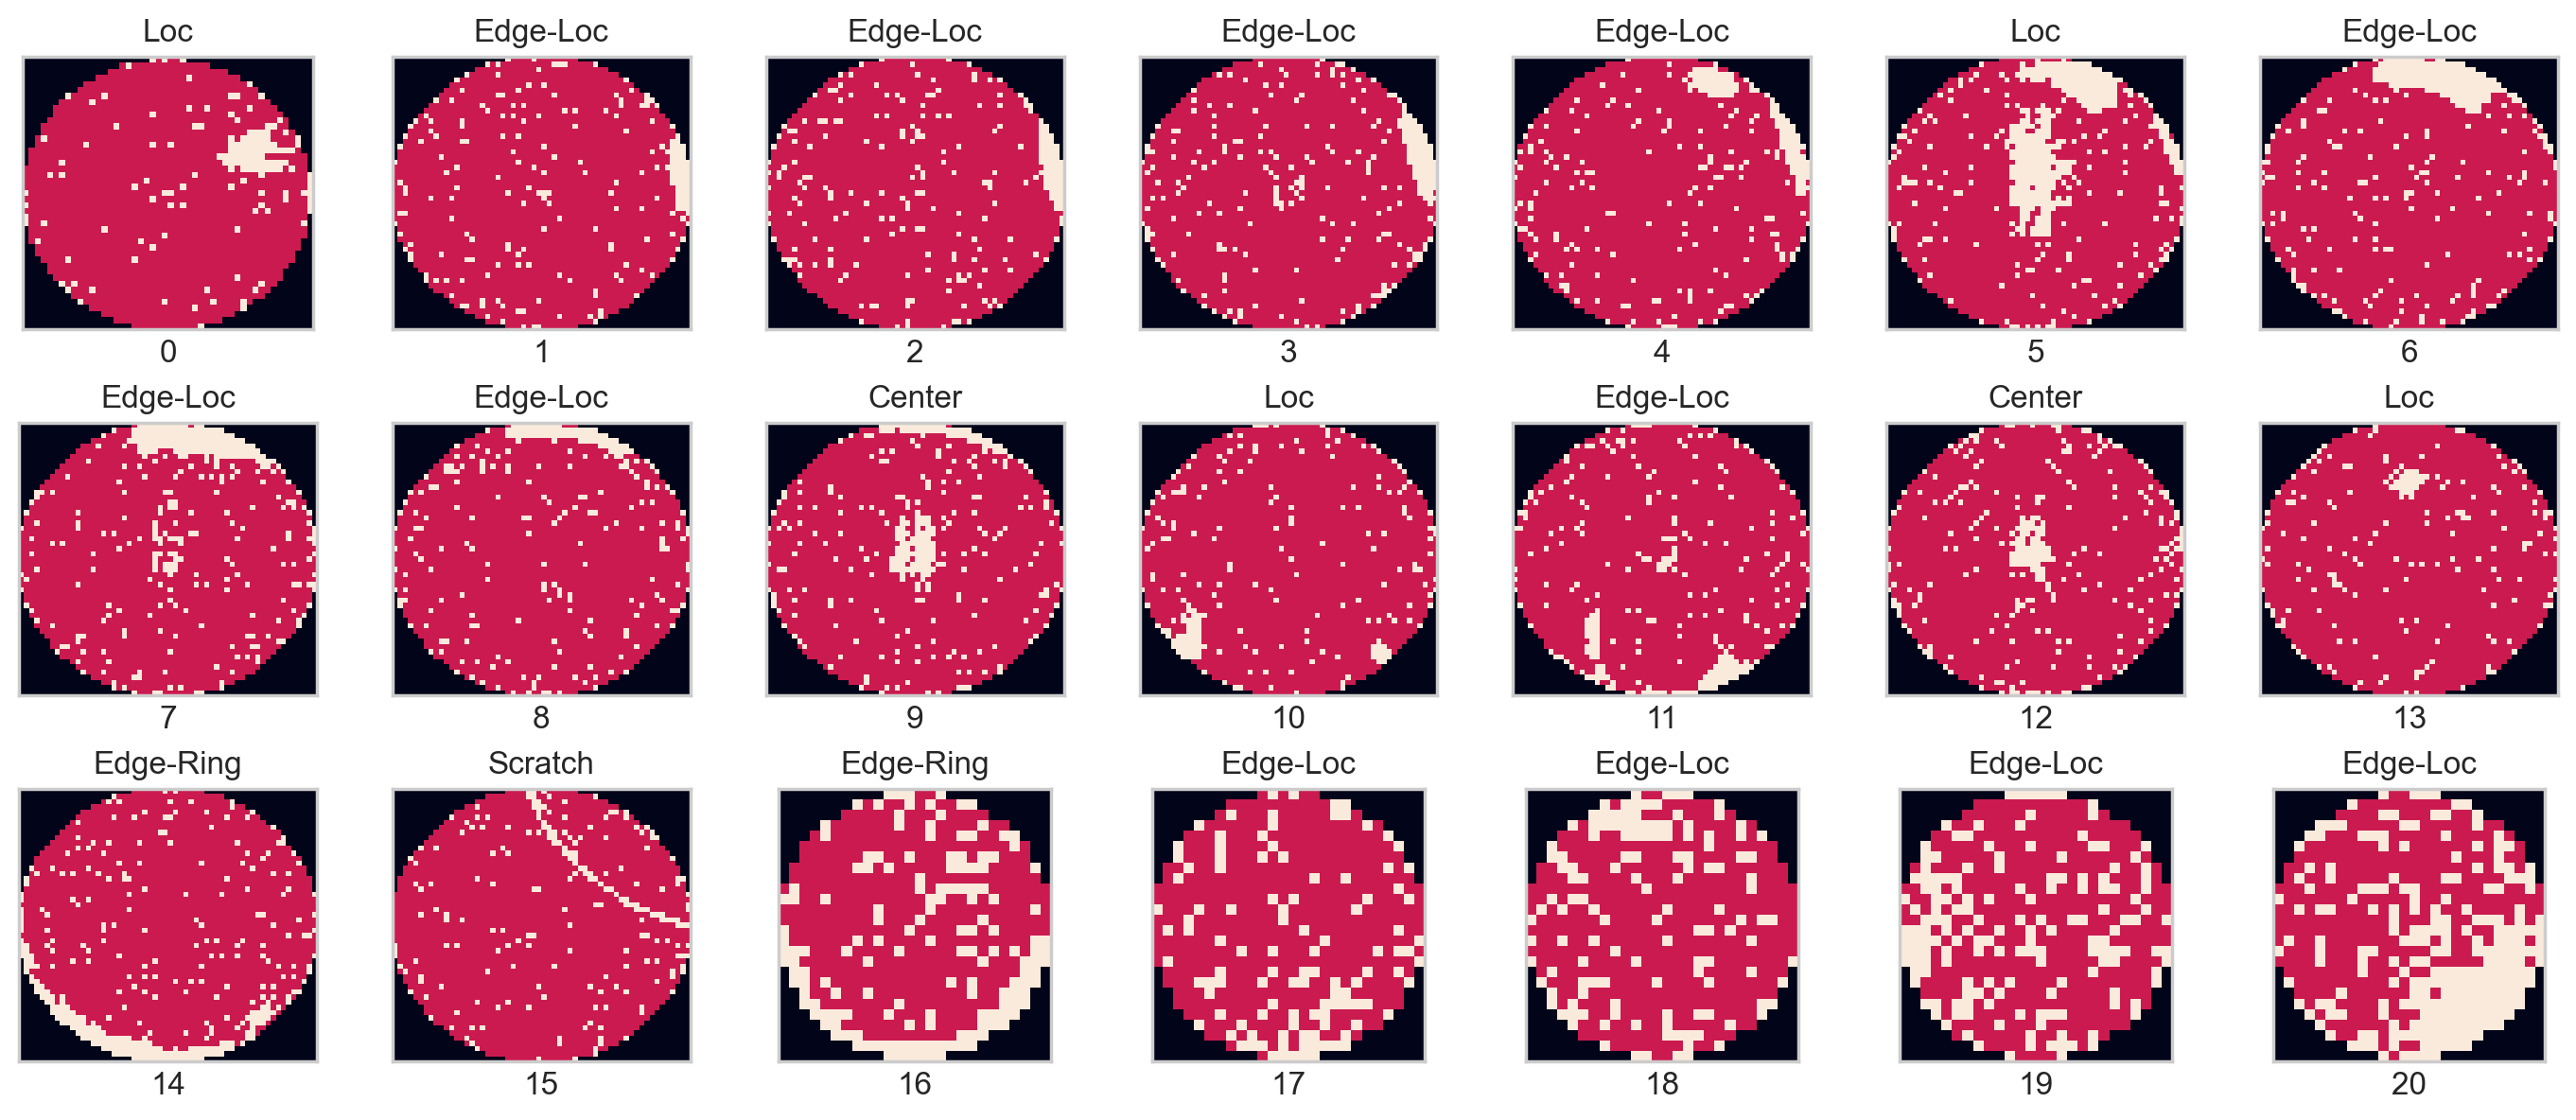

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_withpattern is a DataFrame containing waferMap images and failureType labels

# Create a 10x10 grid of subplots
fig, ax = plt.subplots(nrows=3, ncols=7, figsize=(14, 6))
ax = ax.ravel()  # Flatten the 2D array of axes to 1D

# Iterate over the images and corresponding labels
for i in range(21):
    img = df_withpattern.waferMap[i]  # Get the image from the DataFrame
    ax[i].imshow(img)  # Display the image with green and yellow colormap
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=12)  # Set the title with the failure type
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=12)  # Set the xlabel with the index
    ax[i].set_xticks([])  # Remove x-axis ticks
    ax[i].set_yticks([])  # Remove y-axis ticks

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


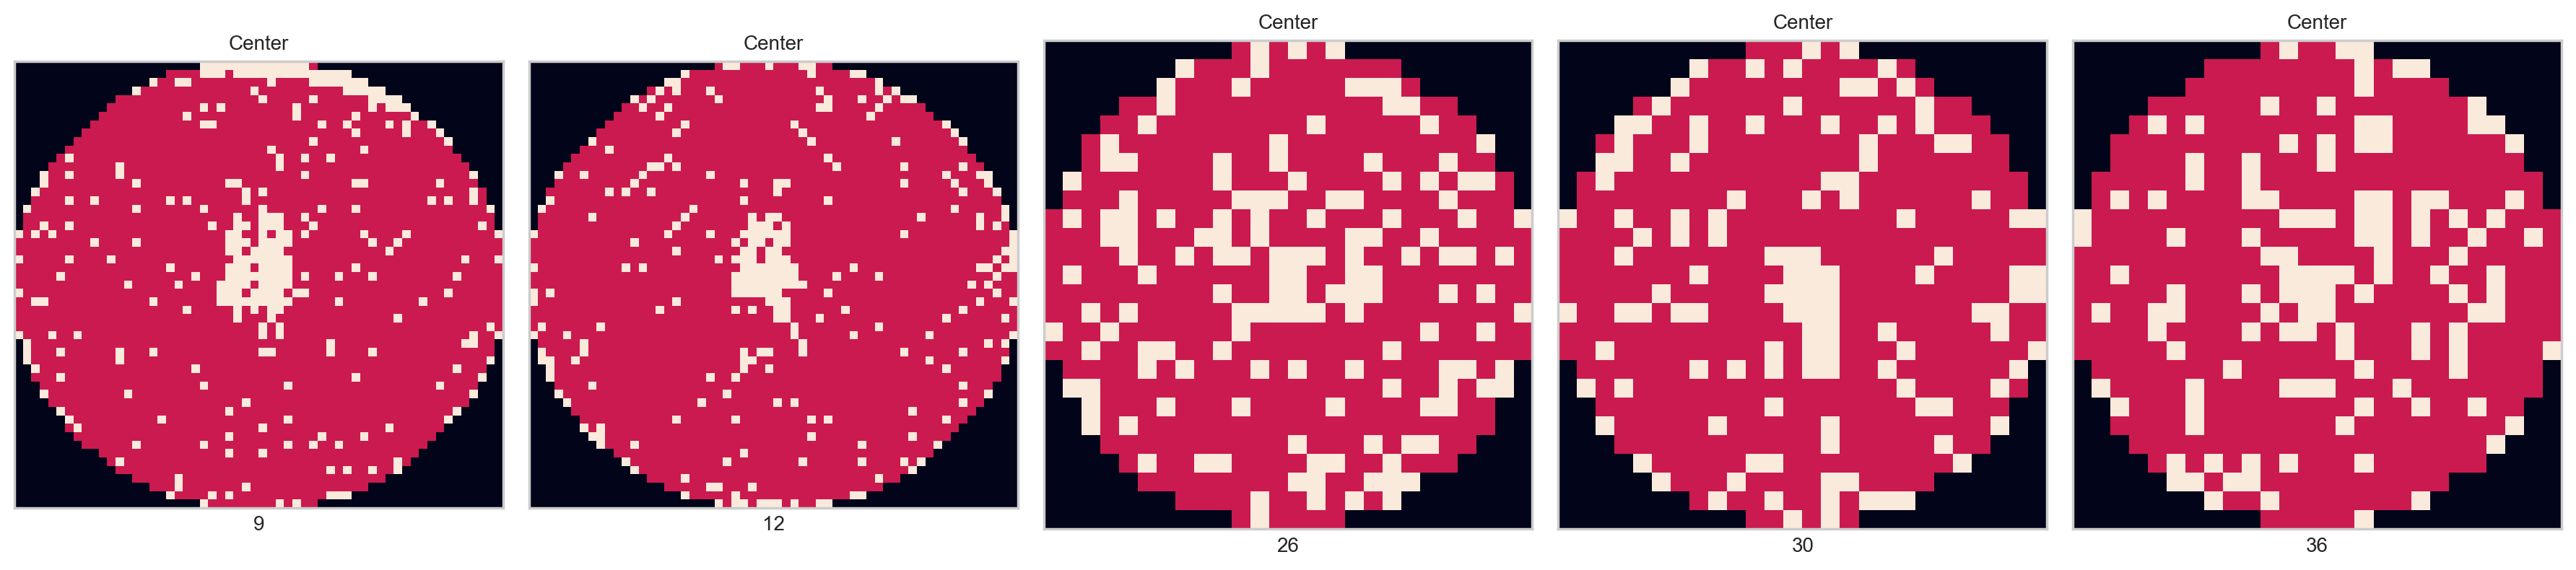

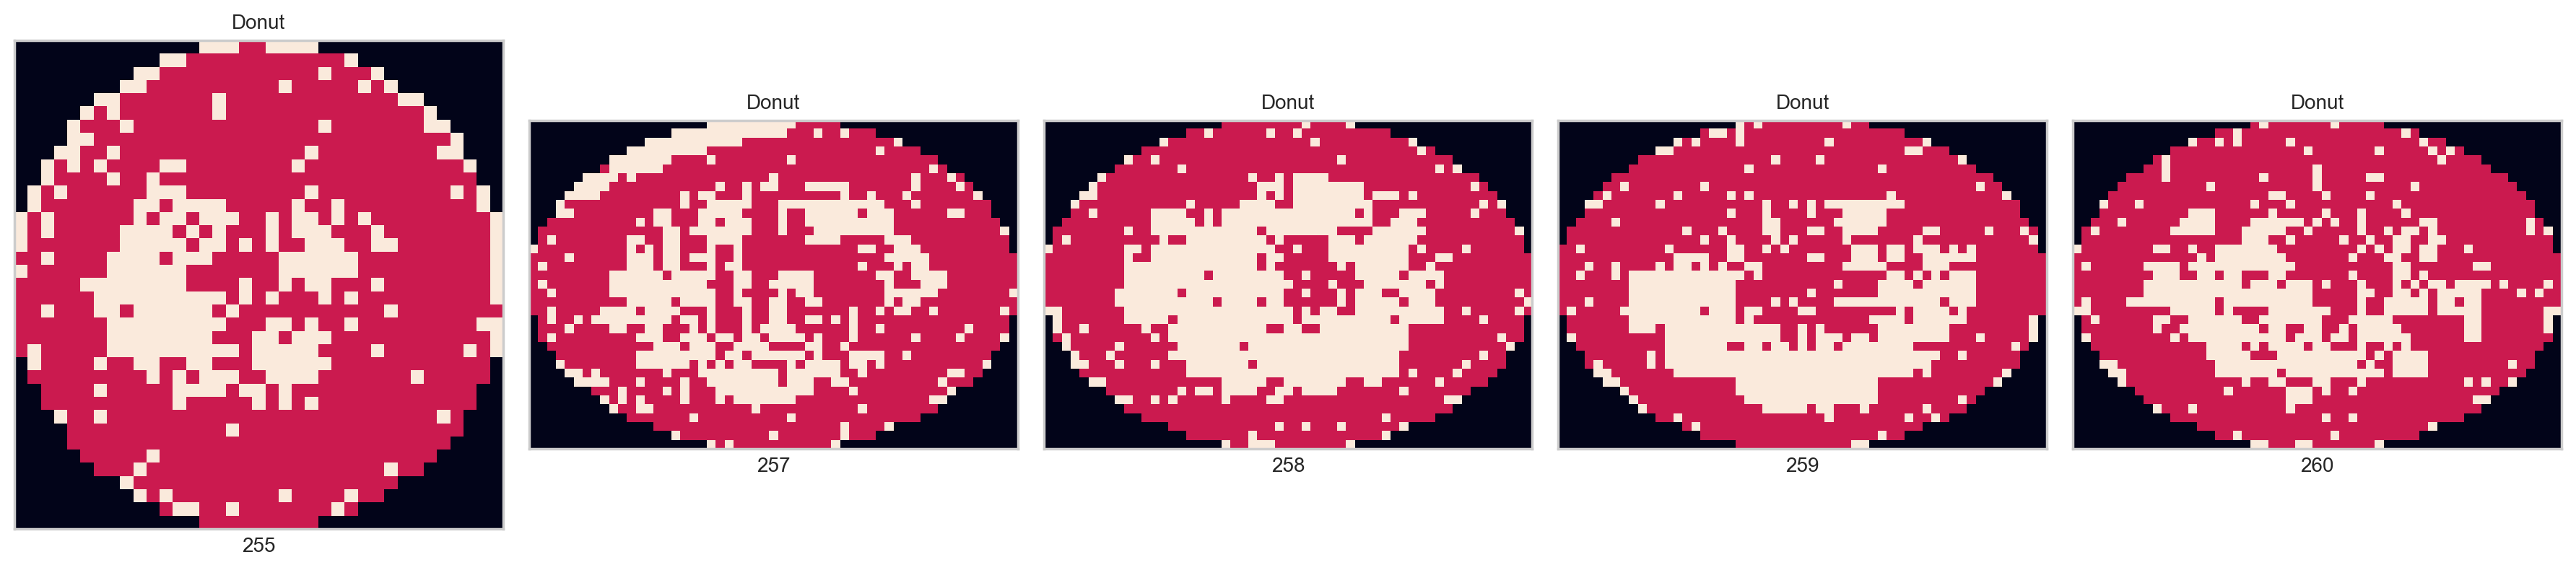

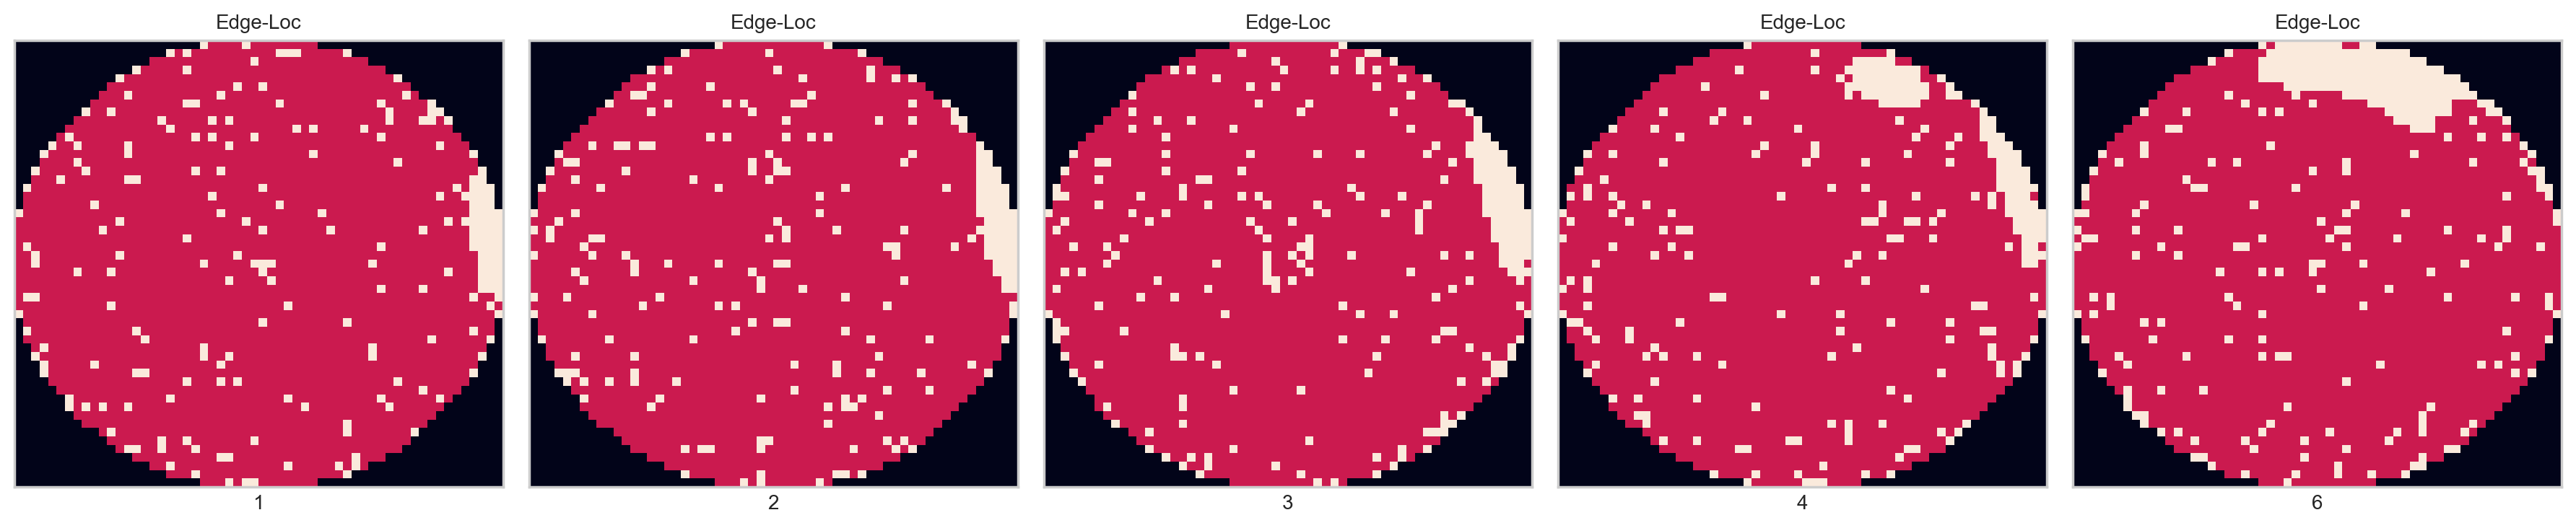

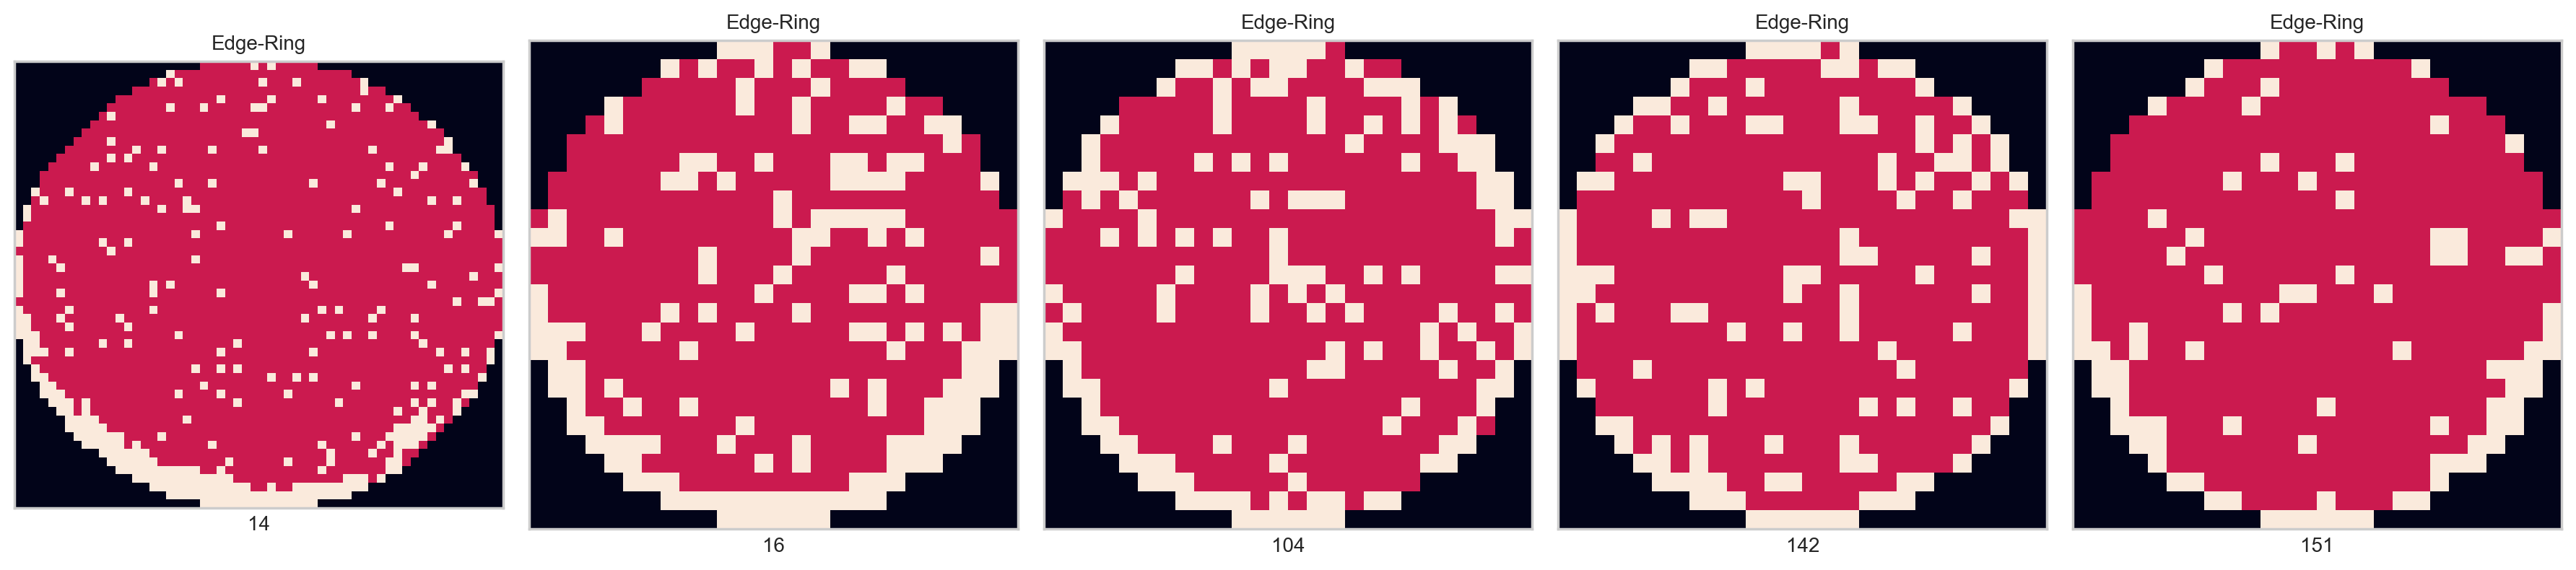

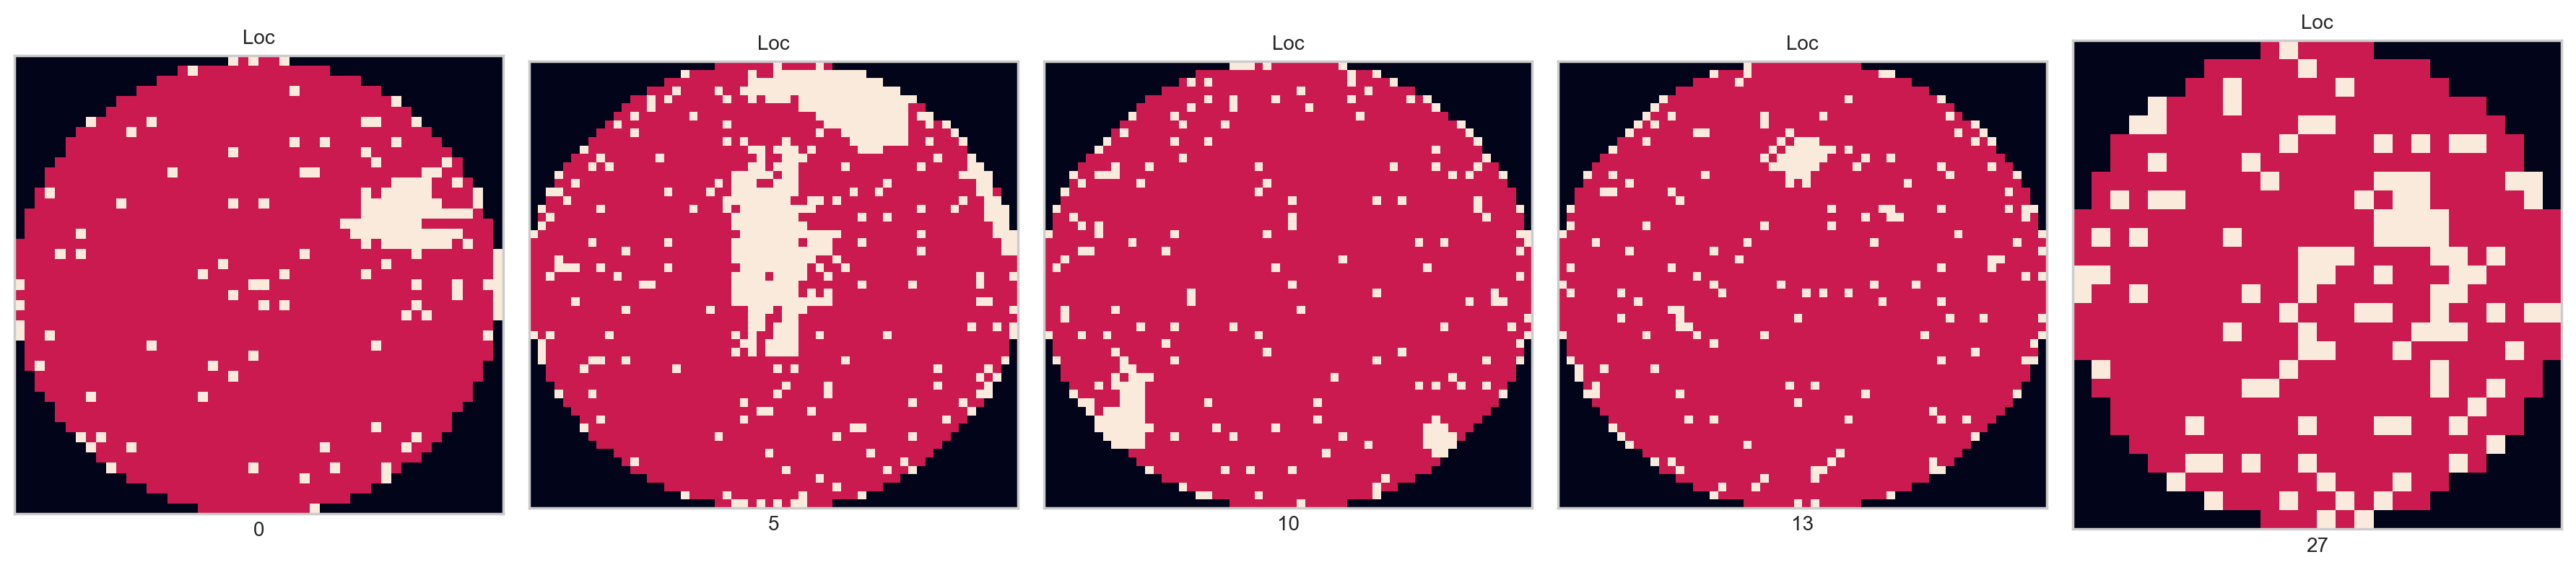

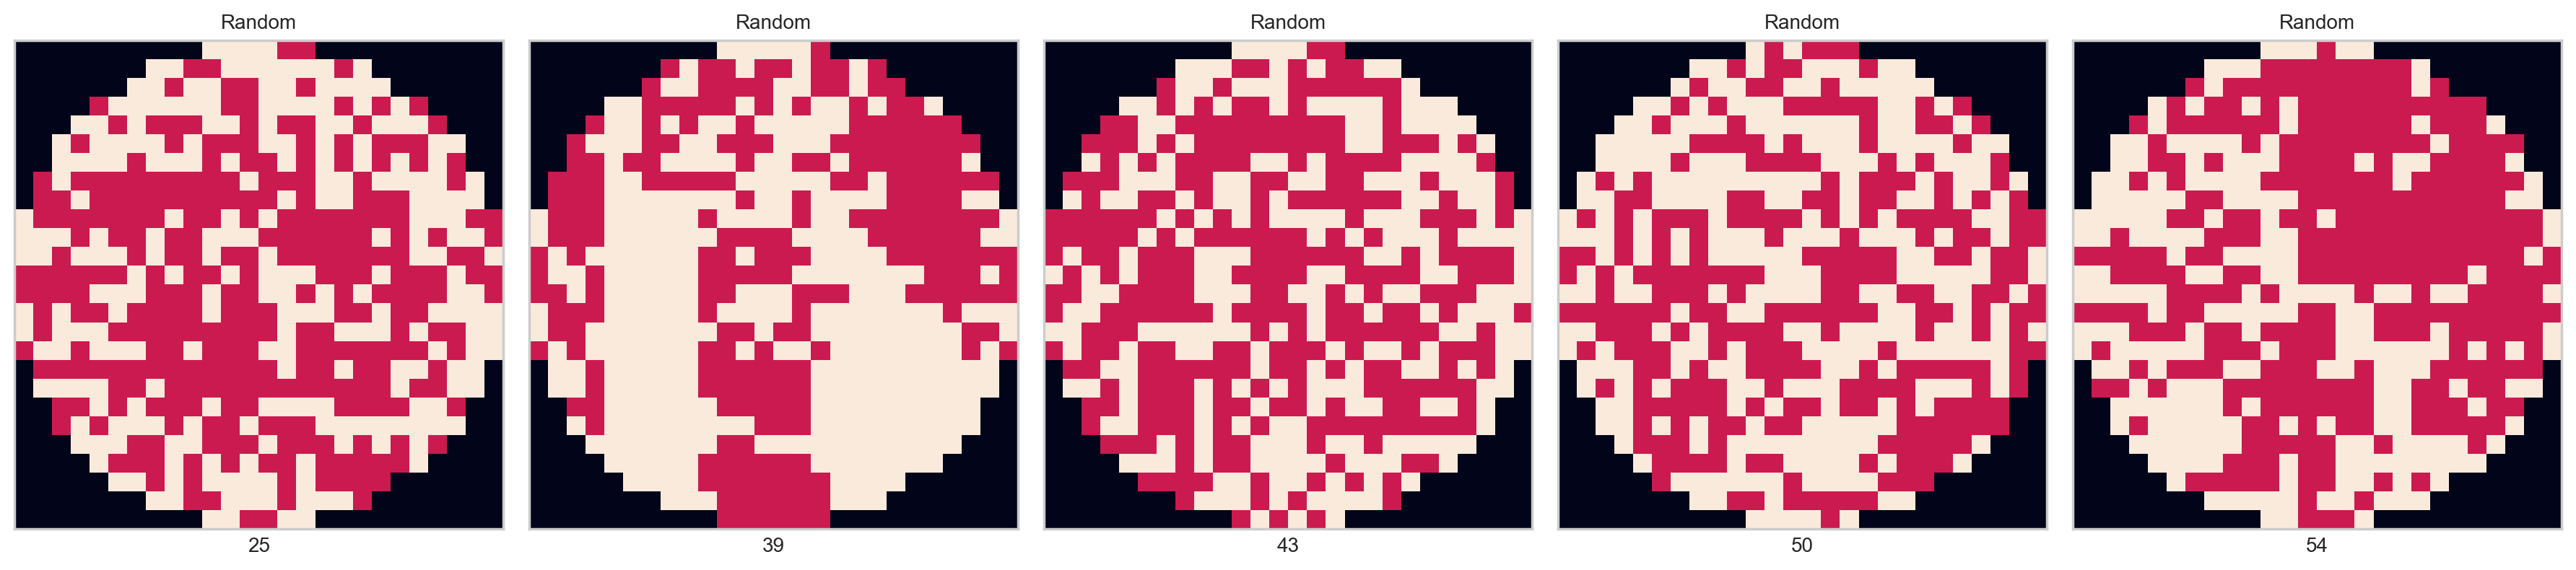

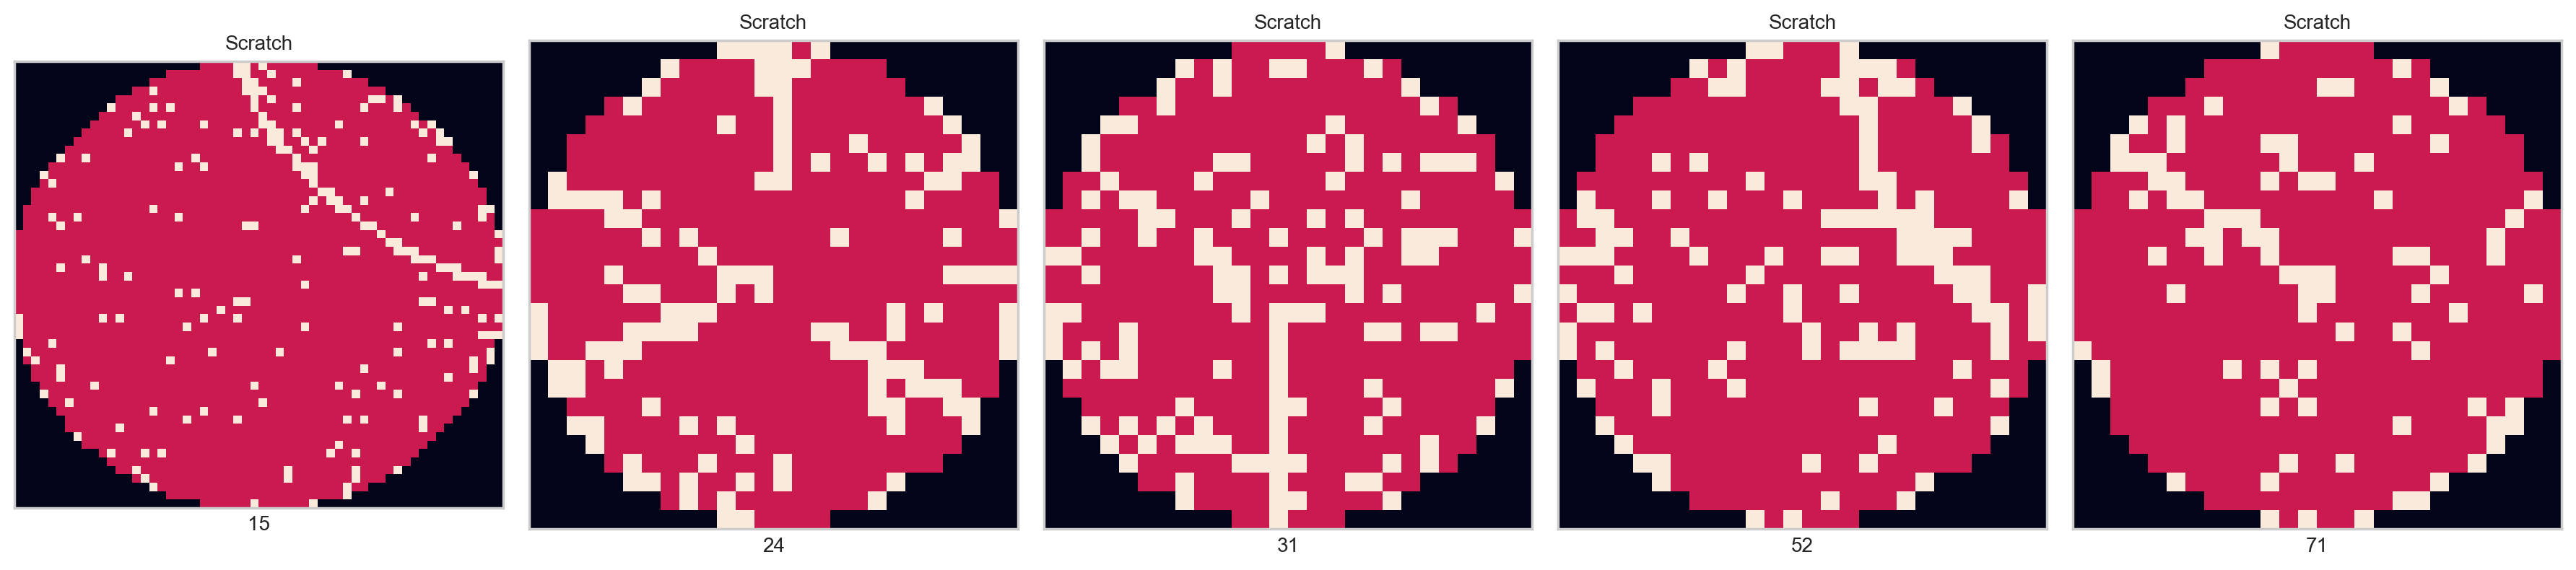

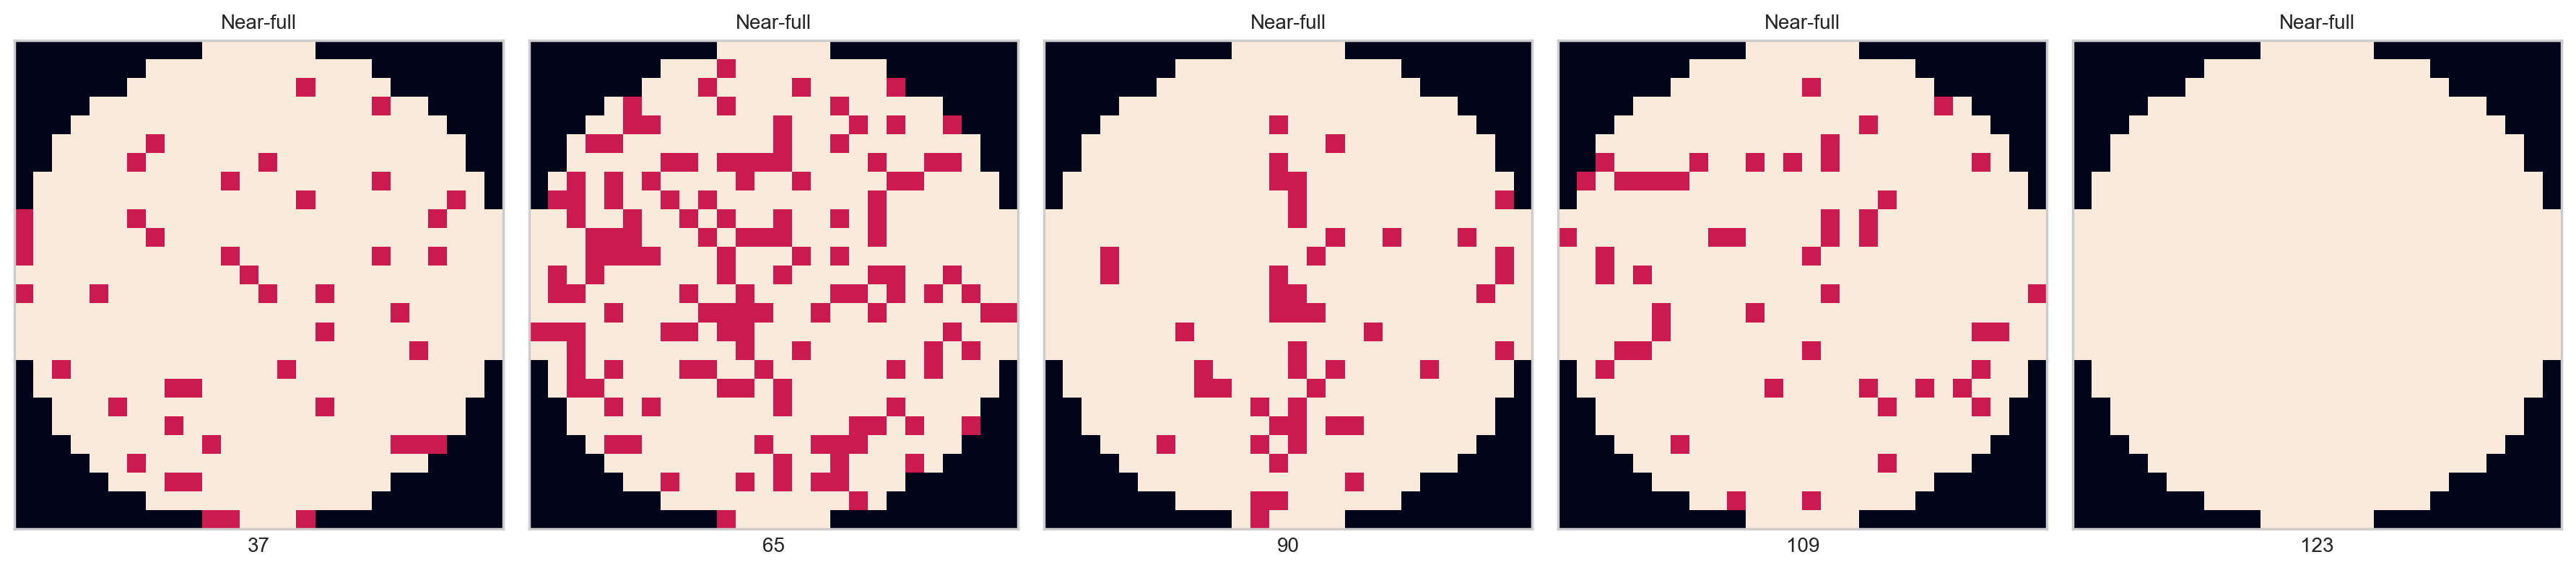

In [12]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for i in range(5):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

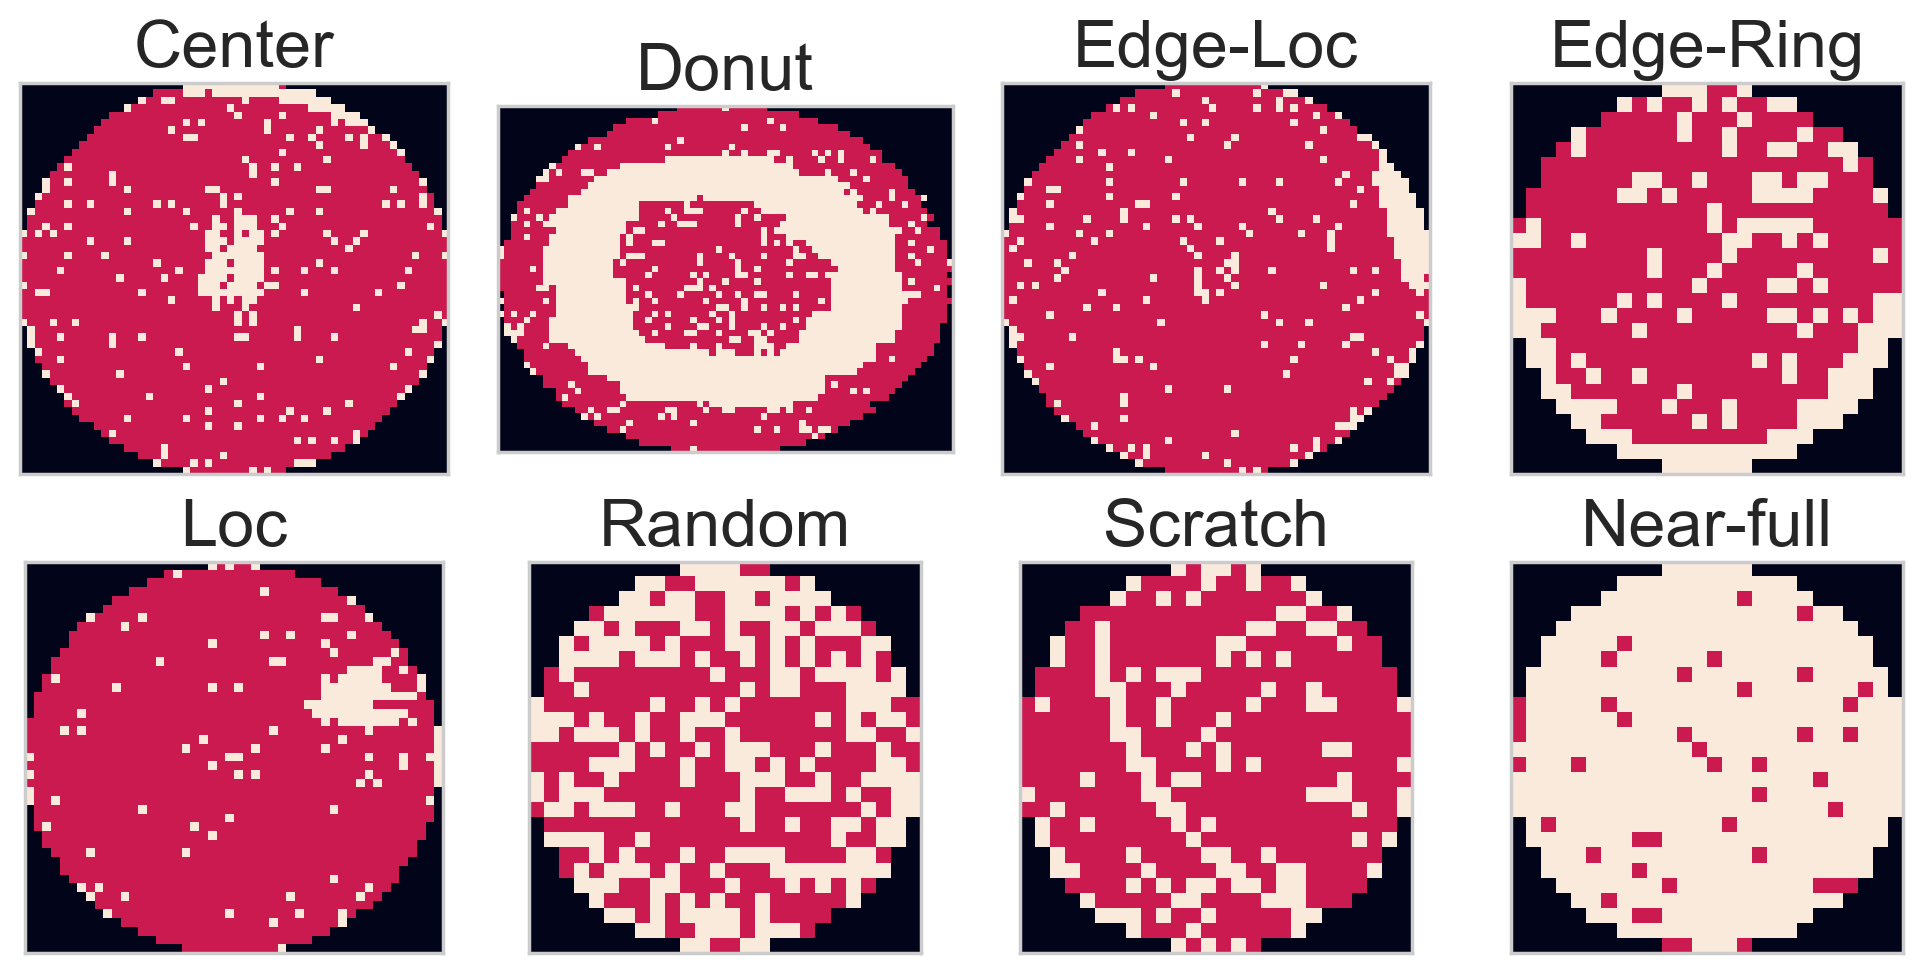

In [13]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(10, 5))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

---

# Image Processing

In [14]:
# !pip install pytorch-metric-learning==1.6.2
# # !pip install -q pytorch-metric-learning[with-hooks]
# !pip install -q scanpy
# !pip install faiss-cpu

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [16]:
model = Sequential([
    # Input
    Input(shape=(224, 224, 3)),
    
    # block 1
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    
    # block 5
    SpatialDropout2D(rate=0.2),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(9, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 111, 111, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 111, 111, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 55, 55, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 55, 55, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 55, 55, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 27, 27, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 27, 27, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 13, 13, 128)    │             

 Total params: 2,536,985 (9.68 MB)

 Trainable params: 2,536,025 (9.67 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
import cv2

def reshape_images(images, height, width):
    reshaped_images = np.zeros((len(images), height, width, 3))
    for n in range(len(images)):
        for h in range(height):
            for w in range(width):
                reshaped_images[n, h, w, images[n][h][w]] = 1
    return reshaped_images

def augment_images(images, number=None):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            rotate=(-180, 180),
            shear=(-8, 8)
        ),
    ], random_order=True)
    
    images_input = np.random.choice(images, number) if number else images
    images_expanded = []
    for image in images_input:
        images_expanded.append(image)
    images_expanded = np.array(images_expanded)
    images_augmented = seq(images=images_expanded)
    return images_augmented

In [18]:
import gc
gc.collect()

13

In [19]:
import numpy as np
import cv2

class_num = 9
dsize = (224, 224)
count_per_class_test = 20
count_per_class = 80

def prepare_data(df, count_per_class, dsize, class_num):
    x_data, y_data = [], []
    for failureNum in range(class_num):
        extracted = df[df['failureNum'] == failureNum].sample(count_per_class, replace=True).waferMap
        resized = extracted.apply(lambda x: cv2.resize(x, dsize=dsize, interpolation=cv2.INTER_AREA))
        augmented = np.array(augment_images(resized))
        reshaped = reshape_images(augmented, dsize[1], dsize[0])
        del augmented

        labels = np.zeros((count_per_class, class_num))
        labels[:, failureNum] = 1  # Efficient one-liner to assign labels
        x_data.extend(reshaped)
        y_data.extend(labels)

    return np.array(x_data), np.array(y_data)

# Prepare test data
x_train, y_train = prepare_data(df_withlabel, count_per_class, dsize, class_num)
x_test, y_test = prepare_data(df_withlabel, count_per_class_test, dsize, class_num)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=100)


Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2012 - loss: 9.9455 - val_accuracy: 0.1278 - val_loss: 13.1509
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 981ms/step - accuracy: 0.3934 - loss: 2.6607 - val_accuracy: 0.1889 - val_loss: 3.4618
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 989ms/step - accuracy: 0.5724 - loss: 1.2117 - val_accuracy: 0.1722 - val_loss: 2.3465


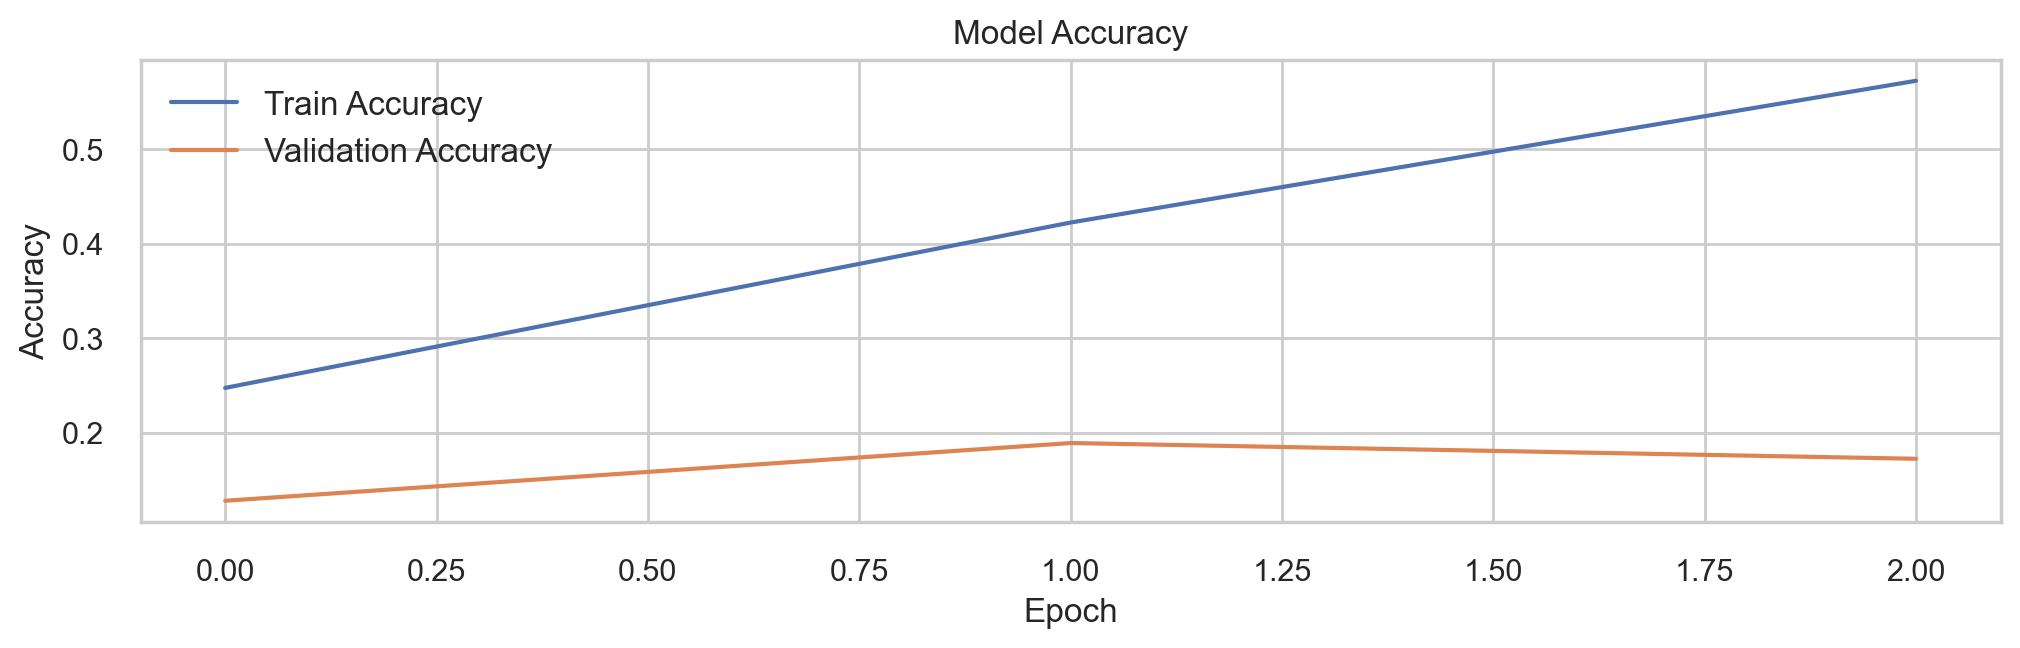

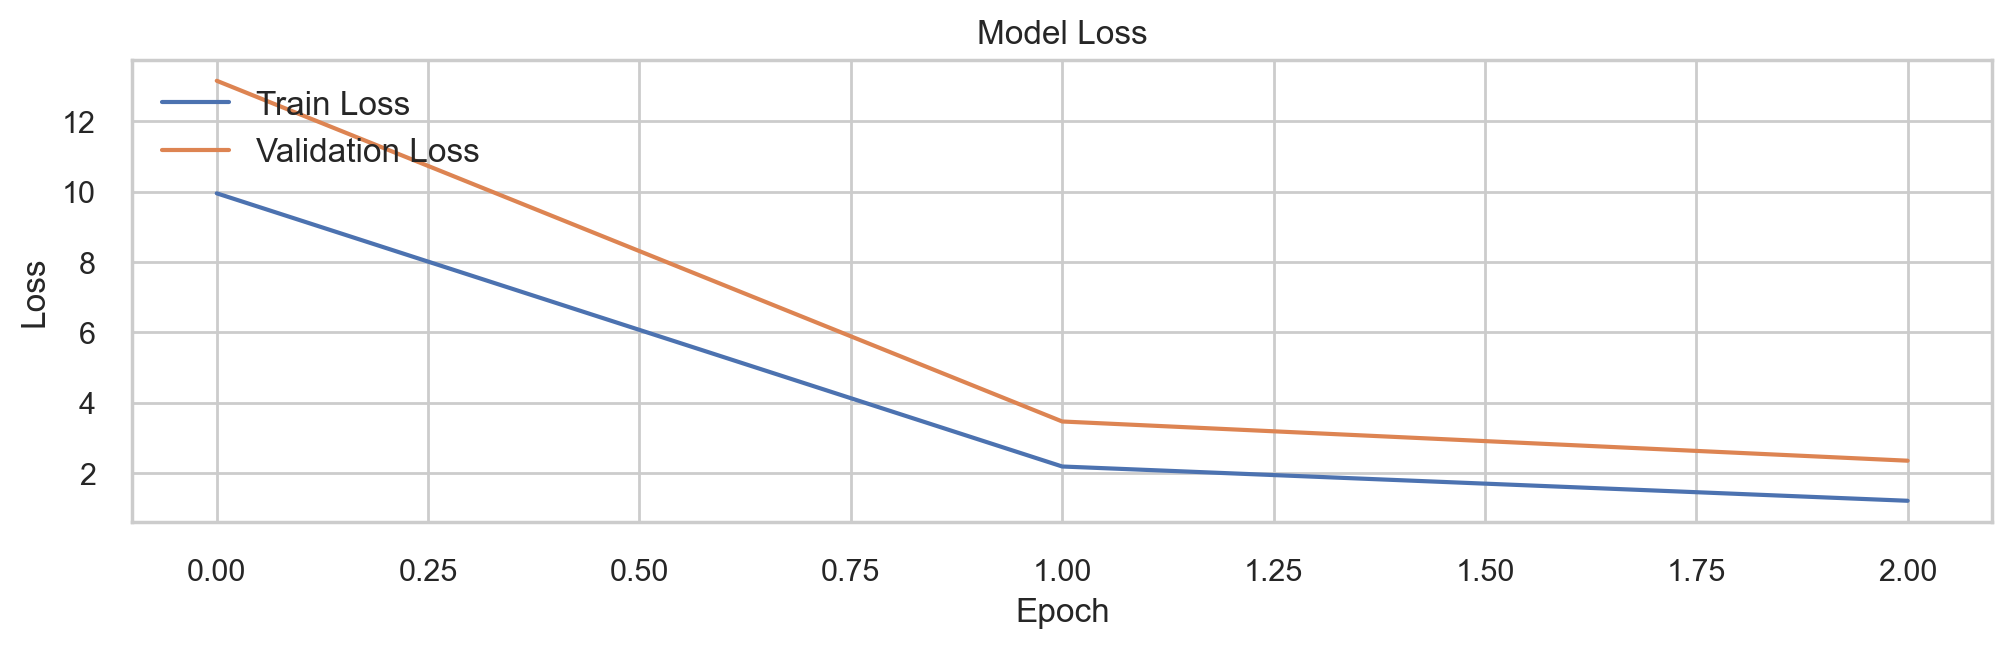

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
              precision    recall  f1-score   support

      Center       0.00      0.00      0.00        20
       Donut       0.00      0.00      0.00        20
    Edge-Loc       0.12      0.25      0.16        20
   Edge-Ring       0.33      0.05      0.09        20
         Loc       0.00      0.00      0.00        20
      Random       0.16      1.00      0.27        20
     Scratch       0.00      0.00      0.00        20
   Near-full       1.00      0.25      0.40        20
        None       0.00      0.00      0.00        20

    accuracy                           0.17       180
   macro avg       0.18      0.17      0.10       180
weighted avg       0.18      0.17      0.10       180



/Users/egn/miniforge3/envs/ml2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egn/miniforge3/envs/ml2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/egn/miniforge3/envs/ml2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


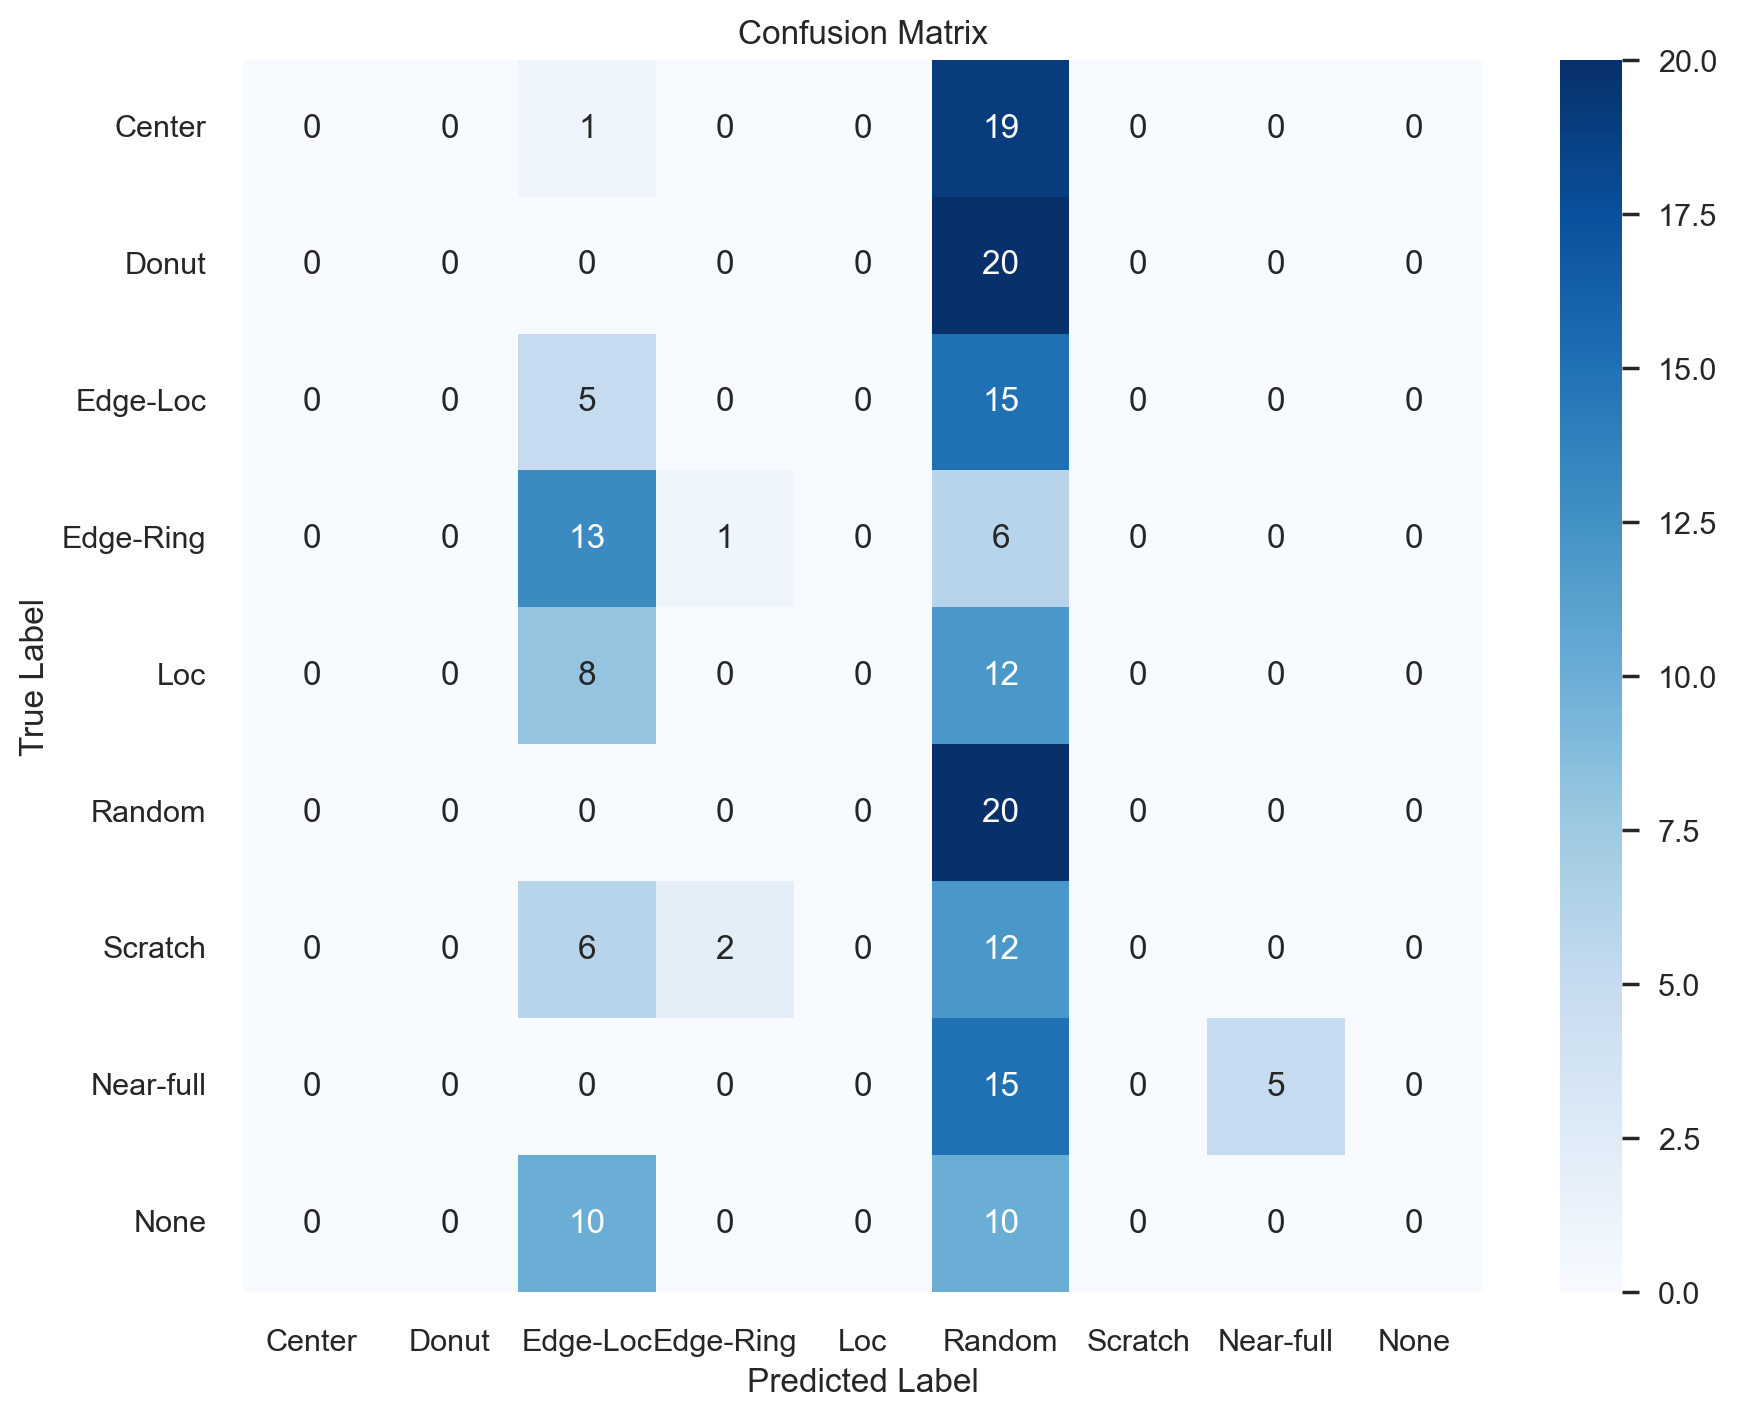

In [21]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

# Define the label dictionary
dic = {
    'Center': 0,
    'Donut': 1,
    'Edge-Loc': 2,
    'Edge-Ring': 3,
    'Loc': 4,
    'Random': 5,
    'Scratch': 6,
    'Near-full': 7,
    'None': 8
}

# Predict categories
y_pred = model.predict(x_test)
predicted_categories = np.argmax(y_pred, axis=1)
true_categories = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(true_categories, predicted_categories, target_names=list(dic.keys())))

# Compute confusion matrix
cm = confusion_matrix(true_categories, predicted_categories)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(dic.keys()), yticklabels=list(dic.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()